In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import random
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tqdm import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
img_size = (224, 224)

In [4]:
datadir = '/content/drive/MyDrive/ml project/pneumonia/train'
categories = ['normal', 'pneumonia']
train = []

for category in categories:
  path = os.path.join(datadir, category)
  class_num = categories.index(category)
  for img in tqdm(os.listdir(path)):
    img_array = cv2.imread(os.path.join(path,img))
    new_array = cv2.resize(img_array, img_size)
    train.append([new_array, class_num])

100%|██████████| 3878/3878 [02:03<00:00, 31.42it/s]


In [5]:
random.shuffle(train)

In [6]:
X_train = []
y_train = []

for features, labels in tqdm(train):
  X_train.append(features)
  y_train.append(labels)

X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 5219/5219 [00:00<00:00, 1022375.07it/s]


In [7]:
import gc
del train
gc.collect()

20

In [8]:
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)

X_train:  (5219, 224, 224, 3)
y_train:  (5219,)


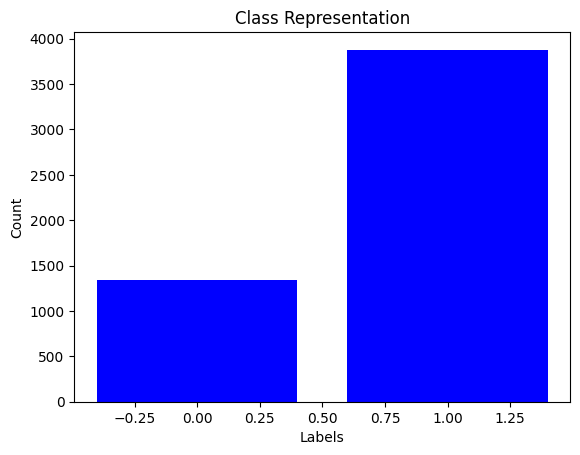

In [9]:
unique_labels, counts = np.unique(y_train, return_counts=True)

# Create a bar chart
plt.bar(unique_labels, counts, color='blue')

# Add labels and title
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Class Representation')

# Show the plot
plt.show()

In [10]:
datadir = '/content/drive/MyDrive/ml project/pneumonia/val'
categories = ['normal', 'pneumonia']
val = []

for category in categories:
  path = os.path.join(datadir, category)
  class_num = categories.index(category)
  for img in tqdm(os.listdir(path)):
    img_array = cv2.imread(os.path.join(path,img))
    new_array = cv2.resize(img_array, img_size)
    val.append([new_array, class_num])

100%|██████████| 8/8 [00:03<00:00,  2.10it/s]


In [11]:
random.shuffle(val)

In [12]:
X_val = []
y_val = []

for features, labels in tqdm(val):
  X_val.append(features)
  y_val.append(labels)

X_val = np.array(X_val)
y_val = np.array(y_val)

100%|██████████| 16/16 [00:00<00:00, 193956.25it/s]


In [13]:
print("X_val: ", X_val.shape)
print("y_val: ", y_val.shape)

X_val:  (16, 224, 224, 3)
y_val:  (16,)


In [14]:
import gc
del val
gc.collect()

3628

In [15]:
datadir = '/content/drive/MyDrive/ml project/pneumonia/test'
categories = ['normal', 'pneumonia']
test = []

for category in categories:
  path = os.path.join(datadir, category)
  class_num = categories.index(category)
  for img in tqdm(os.listdir(path)):
    img_array = cv2.imread(os.path.join(path,img))
    new_array = cv2.resize(img_array, img_size)
    test.append([new_array, class_num])

100%|██████████| 399/399 [00:08<00:00, 47.29it/s]


In [16]:
random.shuffle(test)

In [17]:
X_test = []
y_test = []

for features, labels in tqdm(test):
  X_test.append(features)
  y_test.append(labels)

X_test = np.array(X_test)
y_test = np.array(y_test)

100%|██████████| 633/633 [00:00<00:00, 813168.28it/s]


In [18]:
print("X_test: ", X_test.shape)
print("y_test: ", y_test.shape)

X_test:  (633, 224, 224, 3)
y_test:  (633,)


In [19]:
import gc
del test
gc.collect()

0

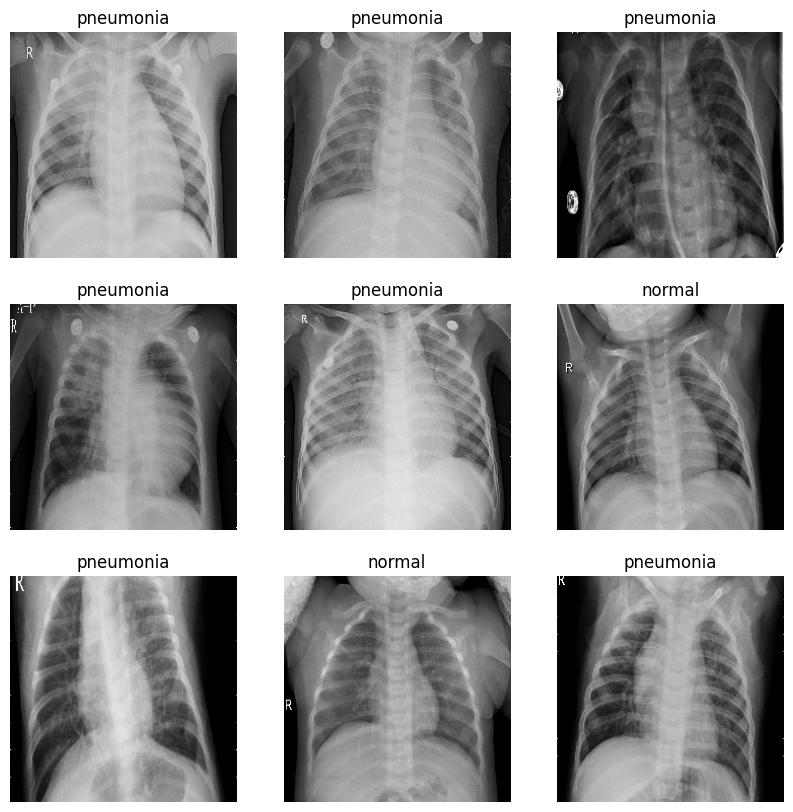

In [20]:
plt.figure(figsize = (10,10))
for i in range(9):
  ax = plt.subplot(3,3,i+1)
  plt.imshow(X_train[i], cmap = 'gray')
  plt.title(categories[y_train[i]])
  plt.axis('off')

In [21]:
base_model = VGG16(weights='imagenet', include_top = False, input_shape = X_train[0].shape)
base_model.trainable = False

58889256/58889256 [==============================] - 2s 0us/step


In [22]:
# X_train = preprocess_input(X_train)
# X_test = preprocess_input(X_test)

In [23]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [24]:
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation = 'relu')
dense_layer_2 = layers.Dense(10, activation = 'relu')
prediction_layer = layers.Dense(1, activation = 'sigmoid')

model = models.Sequential([base_model,
                           flatten_layer,
                           dense_layer_1,
                           dense_layer_2,
                           prediction_layer])

In [25]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight = "balanced",
                                        classes = np.unique(y_train),
                                        y = y_train)
class_weights = dict(zip(np.unique(y_train), class_weights))
class_weights

{0: 1.9459358687546606, 1: 0.6728984012377515}

In [26]:
opt = tf.keras.optimizers.Adam(learning_rate=0.005)
model.compile(optimizer = opt,
              loss = 'binary_crossentropy',
              metrics = ['accuracy'],)
es = EarlyStopping(monitor = 'val_accuracy', mode = 'auto', patience = 5, restore_best_weights = True)
hist = model.fit(X_train, y_train, epochs = 10, batch_size=8, callbacks=[es], validation_data=(X_val, y_val), validation_batch_size=2, shuffle=True, class_weight=class_weights)

Epoch 1/10
653/653 [==============================] - 39s 49ms/step - loss: 3.4317 - accuracy: 0.9337 - val_loss: 0.1452 - val_accuracy: 0.9375
Epoch 2/10
653/653 [==============================] - 30s 46ms/step - loss: 0.2631 - accuracy: 0.9644 - val_loss: 0.1022 - val_accuracy: 1.0000
Epoch 3/10
653/653 [==============================] - 30s 46ms/step - loss: 0.0963 - accuracy: 0.9747 - val_loss: 0.0622 - val_accuracy: 1.0000
Epoch 4/10
653/653 [==============================] - 30s 47ms/step - loss: 0.0643 - accuracy: 0.9782 - val_loss: 0.0330 - val_accuracy: 1.0000
Epoch 5/10
653/653 [==============================] - 31s 47ms/step - loss: 0.0453 - accuracy: 0.9835 - val_loss: 0.0062 - val_accuracy: 1.0000
Epoch 6/10
653/653 [==============================] - 31s 47ms/step - loss: 0.1086 - accuracy: 0.9872 - val_loss: 0.0422 - val_accuracy: 1.0000
Epoch 7/10
653/653 [==============================] - 31s 48ms/step - loss: 0.0497 - accuracy: 0.9920 - val_loss: 0.0142 - val_accuracy:

In [39]:
model.save('/content/drive/MyDrive/ml project/pneumonia/model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


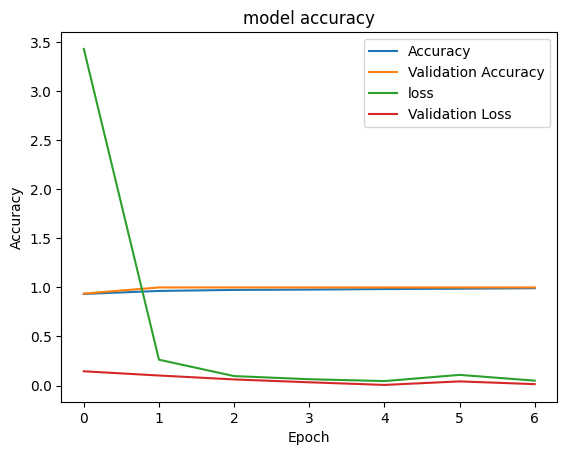

In [41]:
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

In [27]:
y_pred = model.predict(X_test)

20/20 [==============================] - 14s 397ms/step


In [28]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [29]:
y_pred = y_pred.reshape(-1)
y_pred.shape

(633,)

In [30]:
for i in range(y_pred.shape[0]):
  if y_pred[i]>0.75:
    y_pred[i] = 1
  else:
    y_pred[i] = 0

In [31]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.94      0.80      0.86       234
           1       0.89      0.97      0.93       399

    accuracy                           0.91       633
   macro avg       0.91      0.89      0.90       633
weighted avg       0.91      0.91      0.91       633



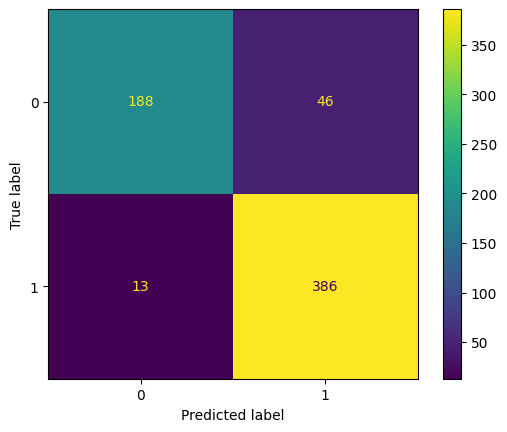

In [32]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()